In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('data/batch3.pkl', 'rb') as f:
    data = np.load(f)

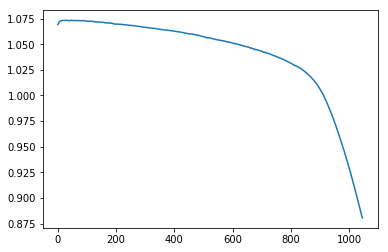

In [3]:
plt.plot(data['b3c43']['summary']['cycle'], data['b3c43']['summary']['QD'])
plt.show()

In [4]:
print('Cell count: ', len(data))
print('Cell names: ', data.keys())

Cell count:  46
Cell names:  dict_keys(['b3c0', 'b3c1', 'b3c2', 'b3c3', 'b3c4', 'b3c5', 'b3c6', 'b3c7', 'b3c8', 'b3c9', 'b3c10', 'b3c11', 'b3c12', 'b3c13', 'b3c14', 'b3c15', 'b3c16', 'b3c17', 'b3c18', 'b3c19', 'b3c20', 'b3c21', 'b3c22', 'b3c23', 'b3c24', 'b3c25', 'b3c26', 'b3c27', 'b3c28', 'b3c29', 'b3c30', 'b3c31', 'b3c32', 'b3c33', 'b3c34', 'b3c35', 'b3c36', 'b3c37', 'b3c38', 'b3c39', 'b3c40', 'b3c41', 'b3c42', 'b3c43', 'b3c44', 'b3c45'])


In [5]:
key = next(iter(data.keys()))
cell = data[key]

In [6]:
summary = data[key]['summary']
summary_keys = summary.keys()
print('keys:', summary_keys)
print('cycle: ', len(summary['QD']))

keys: dict_keys(['IR', 'QC', 'QD', 'Tavg', 'Tmin', 'Tmax', 'chargetime', 'cycle'])
cycle:  1008


In [7]:
print(cell['cycles']['0'].keys())

dict_keys(['I', 'Qc', 'Qd', 'Qdlin', 'T', 'Tdlin', 'V', 'dQdV', 't'])


In [8]:
def get_dataset(d, n_cycles, n_inputs):
    data = None
    
    for name, cell in d.items():
        for i in range(n_cycles):
            cycle = cell['cycles'][str(i)]
            features = []
            for key in cycle.keys():
                features.append(cycle[key][:n_inputs])
            x = np.array(features).flatten()
            y = len(cell['summary']['cycle'])
            xy = np.array([x, y])
            if data is None:
                data = xy
            else:
                data = np.vstack([data, xy])
    return data

# How many cycles to look at?
n_cycles = 10
# How many events per cycle?
n_inputs = 700
dataset = get_dataset(data, n_cycles, n_inputs)

split = int(0.8 * len(dataset))
data_train = dataset[:split]
data_val = dataset[split:]
print('len of inp: ', len(data_val[0,0]))
print('data: ', data_val[0])

len of inp:  6300
data:  [array([ 0.32977711,  0.61317097,  0.84046451, ..., 41.329215  ,
       41.41285167, 41.49646   ])
 922]


In [9]:
'''
Just a simple linear MLP.
'''
class BaselineModel(Model):
    def __init__(self, n_inputs, n_layers=5, n_neurons=256):
        super(BaselineModel, self).__init__()
        
        layers = []
        layers.append(Dense(n_neurons, activation='relu', input_shape=[n_inputs]))
        for _ in range(n_layers-1):
            layers.append(Dense(n_neurons, activation='relu'))
        self.hidden_layers = layers
        self.out = Dense(1)

    def call(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
        return self.out(x)

model = BaselineModel(n_inputs)

In [10]:
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_mse = tf.keras.metrics.MeanSquaredError(name='train_mse')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_mse = tf.keras.metrics.MeanSquaredError(name='test_mse')

In [11]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        predictions = model(x)
        loss = loss_fn(y, predictions)
                
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
    train_loss(loss)
    train_mse(y, predictions)

In [12]:
@tf.function
def test_step(x, y):
    predictions = model(x)
    loss = loss_fn(y, predictions)
  
    test_loss(loss)
    test_mse(y, predictions)

In [ ]:
# will be slow unless you're on a GPU :'(
EPOCHS = 100

train_rmses = []
test_rmses = []
for epoch in range(EPOCHS):
    
    for x, y in data_train:
        train_step(np.array([x]), np.array([y]))

    for x, y in data_val:
        test_step(np.array([x]), np.array([y]))
        
    train_rmses.append(np.sqrt(train_mse.result()))
    test_rmses.append(np.sqrt(test_mse.result()))
    
    template = 'Epoch {}, Loss: {}, RMSE: {}, Test Loss: {}, Test RMSE: {}'
    print(template.format(epoch+1,
                         train_loss.result(), 
                         train_rmses[-1],
                         test_loss.result(), 
                         test_rmses[-1]))

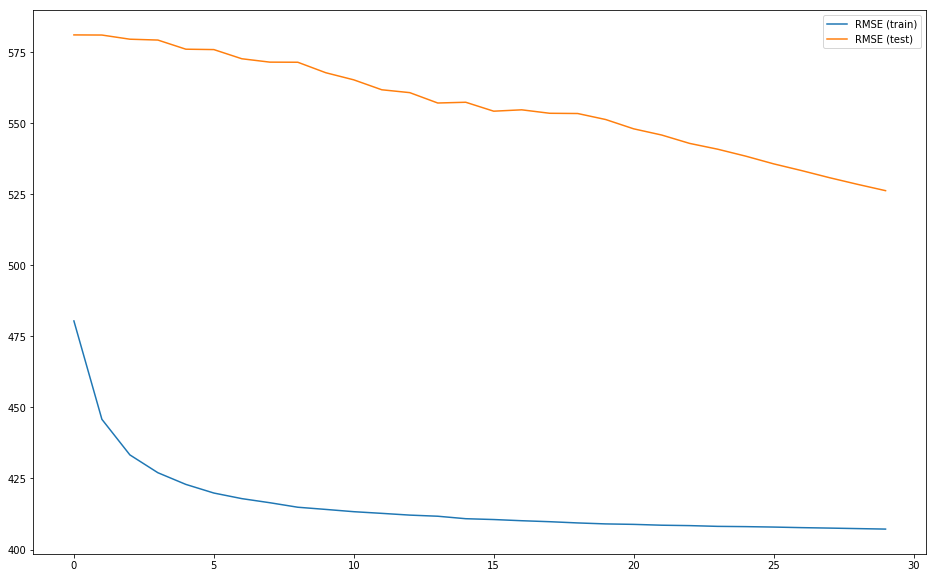

In [14]:
plt.figure(figsize=(16,10))
plt.plot(train_rmses, label='RMSE (train)')
plt.plot(test_rmses, label='RMSE (test)')
plt.legend()
plt.show()